# Data Delivery

This notebook contains a workflow to:
1. Create a NetCDF file containing the outgoing solar radiation data required by the Reflective Earth ROM backend.
1. Create a GeoTIFF file containing the same data for upload to Mapbox.

## Specifications

The Reflective Earth ROM backend requires a NetCDF3 file with latitude and longitude spanning the globe every 0.1 degree (90 to -90 and 0 to 360).

The Mapbox standard projection is Web Mercator (EPSG:3857).

## Preliminaries

### Requirements

* A Google Cloud project with Cloud Storage enabled ([Create new account](https://cloud.google.com/))
* Python packages. See `../environments/environment.deliver.yml`:
  * `xarray`
  * `dask`
  * `netCDF4` 
  * `matplotlib`
  * `rasterio`
  * `google-cloud-storage`
  * `matplotlib`
  * `esmpy`
  * `xesmf`
  * `ipykernel`

In [13]:
from utils import check_environment

check_environment("deliver")

import logging
import os
from sys import platform

from google.cloud import storage
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import rasterio
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
import xarray as xr
import xesmf as xe

### Setup

In [14]:
data_bucket = "rom-input"
data_dir = "../assets"
n_jobs = -2  # for parallelization; if 1, then serial; if negative, then (n_cpus + 1 + n_jobs) are used

# Xarray configuration
xr.set_options(keep_attrs=True)

# Multiprocessing configuration for MacOS
if platform == "darwin":
    multiprocessing.set_start_method("fork", force=True)  # ipython bug workaround https://github.com/ipython/ipython/issues/12396

# Logging configuration
logging.basicConfig(filename="deliver.log", filemode="w", level=logging.INFO)

## Functions

In [17]:
def get_data_gcs(bucket_name, file_name, file_path="."):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        bucket_name: Google Cloud Storage bucket to download from.
        file_name: name of file to download from gcs.
        file_path: path to place file locally.
    
    Returns:
        Nothing; downloads data from Google Cloud Storage.
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)    
    blob = bucket.blob(file_name)
    blob.download_to_filename(filename=os.path.join(file_path, file_name))

## Workflow

In [16]:
get_data_gcs(data_bucket, "rom_analysis.nc", data_dir)

In [8]:
ds_rom = xr.open_dataset(os.path.join(data_dir, "rom_analysis.nc"))
ds_rom = ds_rom.rename_dims({"longitude": "lon",
                             "latitude": "lat"}).rename_vars({"longitude": "lon",
                                                              "latitude": "lat"})

The analyzed ROM data are regridded according to the Reflective Earth backend specifications.

In [9]:
ds_out = xr.Dataset({'lon': (['lon'], np.linspace(0.0, 359.9, 3600)),
                     'lat': (['lat'], np.linspace(90.0, -90.0, 1801)),
                    })
regridder = xe.Regridder(ds_rom, ds_out, 'bilinear', 
                         periodic=True, reuse_weights=False)

In [10]:
ds_rom_prod = regridder(ds_rom)

/opt/conda/envs/deliver/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


In [11]:
ds = xr.Dataset({"osr": (["lat", "lon"], ds_rom_prod.psrosr.values)},
                coords={"lat": (["lat"], ds_rom_prod.lat.values),
                        "lon": (["lon"], ds_rom_prod.lon.values)})

Variable and coordinate attributes are used to store standard metadata for the data, following the CF Conventions.

In [12]:
ds.lat.attrs["long_name"] = "latitude"
ds.lat.attrs["units"] = "degrees_north"
ds.lat.attrs["standard_name"] = "latitude"

In [13]:
ds.lon.attrs["long_name"] = "longitude"
ds.lon.attrs["units"] = "degrees_east"
ds.lon.attrs["standard_name"] = "longitude"

In [14]:
ds.osr.attrs["long_name"] = "outgoing solar radiation"
ds.osr.attrs["units"] = "W m**-2"
ds.osr.attrs["standard_name"] = "toa_outgoing_shortwave_flux"

Global attributes are used to store standard metadata for the dataset, again following the CF Conventions.

In [15]:
ds.attrs["title"] = "Reflectivity Optimization Map"
ds.attrs["institution"] = "Reflective Earth Foundation"
ds.attrs["source"] = "ERA5 (ECMWF Copernicus Climate Change Service)"
ds.attrs["history"] = ("v0.4.1 - 20210729 - Update reflected radiation model (Stephens et al. 2015)\n"
                       "v0.4.0 - 20210728 - Updated 1991-2020 Long-term-mean Outgoing Solar Radiation\n"
                       "v0.3.0 - 20200901 - Updated 1990-2019 Long-term-mean Outgoing Solar Radiation\n"
                       "v0.2.0 - 20200610 - Updated 2017-2019 Long-term-mean Outgoing Solar Radiation\n"
                       "v0.1.2 - 20200516 - Updated 201901 Monthly-mean Outgoing Solar Radiation\n"
                       "v0.1.1 - 20200512 - Updated 20190101 Daily-mean Outgoing Solar Radiation\n"
                       "v0.1.0 - 20200511 - Initialized 20190101 (00 UTC) TOA Incoming Solar Radiation")

In [16]:
ds

<xarray.Dataset>
Dimensions:  (lat: 1801, lon: 3600)
Coordinates:
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
Data variables:
    osr      (lat, lon) float64 34.67 34.67 34.67 34.67 ... 72.15 72.15 72.15
Attributes:
    title:        Reflectivity Optimization Map
    institution:  Reflective Earth Foundation
    source:       ERA5 (ECMWF Copernicus Climate Change Service)
    history:      v0.4.1 - 20210729 - Update reflected radiation model (Steph...

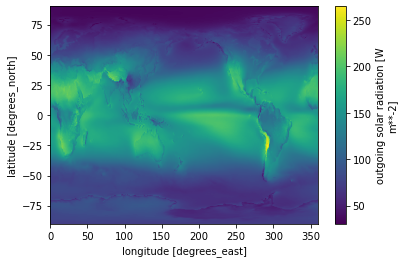

In [17]:
ds.osr.plot()

Recall that the Reflective Earth backend server calls for a NetCDF3 file.

In [13]:
ds.to_netcdf(os.path.join(data_dir, "REF_ROM.nc"), format="NETCDF3_64BIT")

Finally, we prepare the data for rasterization:

In [14]:
lon_name = 'lon'  # whatever name is in the data

# Adjust lon values to make sure they are within (-180, 180)
ds['_longitude_adjusted'] = xr.where(
    ds[lon_name] > 180,
    ds[lon_name] - 360,
    ds[lon_name])

# reassign the new coords to as the main lon coords
# and sort DataArray using new coordinate values
ds = (
    ds
    .swap_dims({lon_name: '_longitude_adjusted'})
    .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
    .drop(lon_name))

ds = ds.rename({'_longitude_adjusted': lon_name})

Next we normalize the data and convert it to unsigned integers.

In [15]:
Z = ((ds.osr.values / ds.osr.max().values) * 256).astype("uint8")
x = ds.lon.values
y = ds.lat.values
res = 0.1

transform = rasterio.transform.from_origin(-180.0, 90.0, 0.1, 0.1)

In [16]:
transform

(180.0, -90.10000000000002)

In [17]:
Z.shape

(1801, 3600)

In [18]:
transform

Affine(0.1, 0.0, -180.0,
       0.0, -0.1, 90.0)

In [19]:
src_crs = CRS.from_string("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")
dst_crs = CRS.from_string("EPSG:4326")

print(src_crs.is_geographic)
print(dst_crs.is_projected)

True
False


We'll use viridis as the primary colormap and save a grayscale version as well.

In [40]:
viridis = cm.get_cmap('viridis', 255)
viridis_cm = viridis(np.linspace(0, 1, 255)) * 255

grays = cm.get_cmap("gist_gray", 255)
grays_cm = grays(np.linspace(0, 1, 255)) * 255

viridis_cmap = {}
for i in range(0, 255):
    viridis_cmap[i+1] = tuple(viridis_cm[i, :])
    
grays_cmap = {}
for i in range(0, 255):
    grays_cmap[i+1] = tuple(grays_cm[i, :])

In [41]:
with rasterio.open(
    os.path.join(data_dir, "REF_ROM_EPSG4326.tif"),
    "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    crs="EPSG:4326",
    transform=rasterio.transform.from_origin(-180.0, 90.0, 0.1, 0.1),
) as dst:
    dst.write_colormap(
            1, viridis_cmap)
    dst.write(Z, 1)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3600, 'height': 1801, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.1, 0.0, -180.0,
       0.0, -0.1, 90.0), 'tiled': False, 'interleave': 'band'}


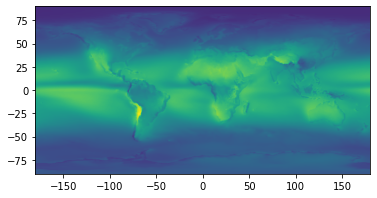

In [42]:
with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG4326.tif"), 'r') as data:
    print(data.profile)
    show(data)

Lastly, we reproject the data to EPSG:3857 and save a viridis colormap version and a grayscale colormap version.

In [33]:
dst_crs = "EPSG:3857"

with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG4326.tif")) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, width=src.width, height=src.height,
        left=-180, bottom=-85.05, right=180, top=85.05)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG3857.tif"), 'w', **kwargs) as dst:
        dst.write_colormap(1, viridis_cmap)
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

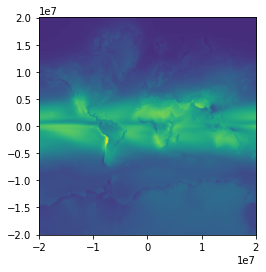

In [34]:
with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG3857.tif"), 'r') as data:
    show(data)

In [35]:
dst_crs = "EPSG:3857"

with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG4326.tif")) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, width=src.width, height=src.height,
        left=-180, bottom=-85.05, right=180, top=85.05)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG3857_gray.tif"), 'w', **kwargs) as dst:
        dst.write_colormap(1, grays_cmap)
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)